In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [156]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [157]:
from src.transformers.sklearn_model import SklearnModel

In [158]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from src.molecule_pairs_opt import MoleculePairsOpt
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [159]:
from src.transformers.embedder import Embedder

In [160]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
drug_plus.mgf
drug_plus.pkl
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
merged_gnps_nist_20240319_unique_smiles_1_million_v2.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05

## Parameters

In [161]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
#uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240319_unique_smiles_1_million_v2.pkl'
#transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
#transformer_path = data_folder + 'best_model_20240318_lib_cos_sim.ckpt'
transformer_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'

In [162]:
THRESHOLD_ANALOG=0.7

In [163]:
load_molecule_pairs_file= True
only_use_gnps=False

In [164]:
## Load spectrum using spectrumutils

In [165]:
config=Config()

In [177]:
config.D_MODEL=512
config.N_LAYERS=5

## Load molecular pairs

In [166]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
        original_molecule_pairs= dataset['uniformed_molecule_pairs_test']
else:
        number_pairs=10000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [167]:
len(original_molecule_pairs)

26650

In [168]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
else:
    molecule_pairs=original_molecule_pairs

In [169]:
len(molecule_pairs)

26650

## Our model

In [170]:
from src.transformers.sklearn_model import SklearnModel

In [171]:
#temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
#                                      indexes_tani =molecule_pairs.indexes_tani)
temp_molecule_pairs= molecule_pairs

In [172]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [178]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [179]:
#next(iter(dataloader_test))

In [180]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [181]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...


33719it [00:00, 80459.99it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26650/26650 [00:00<00:00, 116062.90it/s]


Preprocessing all the data ...


33719it [00:00, 80789.17it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [182]:
scores_trans

array([0.08612324, 0.06360644, 0.06092526, ..., 0.75733495, 1.        ,
       0.98692346])

In [183]:
tanimoto_trans = [row[2] for row in molecule_pairs.indexes_tani]

In [184]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[s if s>0 else 0 for s in (scores_trans)]

In [185]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.8866587394410317, pvalue=0.0)

tpr: [0.         0.0011257  0.00762977 ... 0.99987492 1.         1.        ]
fpr: [0.         0.         0.         ... 0.97732511 0.97732511 1.        ]


(array([0.        , 0.0011257 , 0.00762977, ..., 0.99987492, 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.97732511, 0.97732511,
        1.        ]))

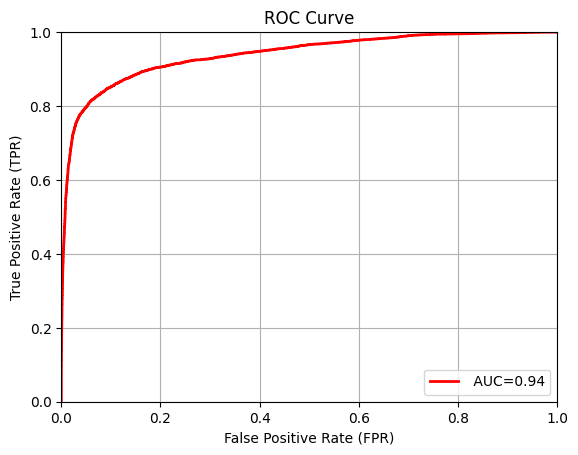

In [186]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

In [187]:
temp_molecule_pairs.prediction = scores_trans

In [188]:
## Separate false positives

In [189]:
molecule_fp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [190]:
molecule_tp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [191]:
molecule_tn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [192]:
molecule_fn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [193]:
## There is a difference in precursor mass difference?

In [194]:
diff_mass_fp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [195]:
diff_mass_tp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [196]:
diff_mass_tn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [197]:
diff_mass_fn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fn]

In [198]:
diff_mass_positives= diff_mass_tp + diff_mass_fn
diff_mass_negatives = diff_mass_tn + diff_mass_fp

In [199]:
len(molecule_tp), len(molecule_fn)

(6088, 1907)

In [200]:
len(molecule_tn), len(molecule_fp)

(18058, 597)

Text(0.5, 0, 'diff mass')

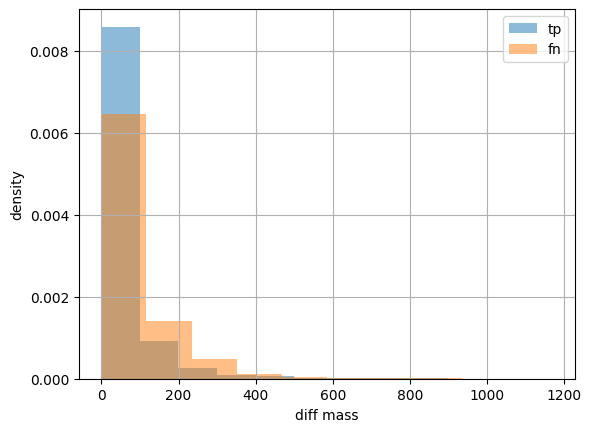

In [201]:
_= plt.hist(diff_mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(diff_mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

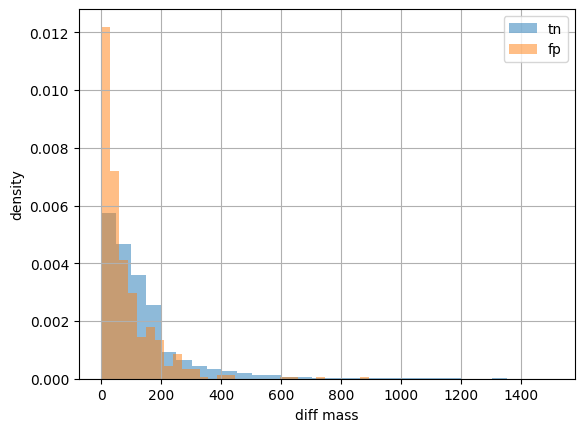

In [202]:
_=plt.hist(diff_mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

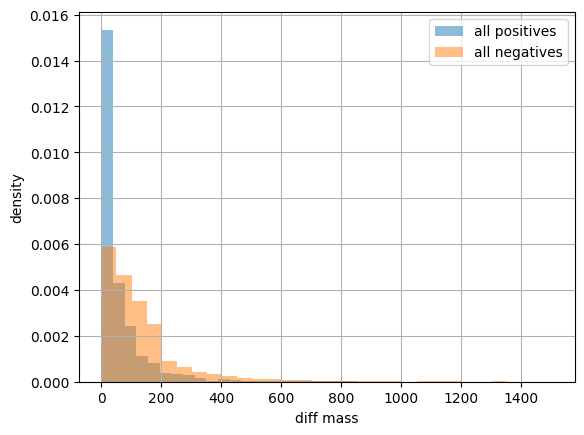

In [203]:
_=plt.hist(diff_mass_positives, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_negatives, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

(array([1.2666e+04, 3.7130e+03, 9.3200e+02, 4.0000e+02, 1.6000e+02,
        9.0000e+01, 3.3000e+01, 3.6000e+01, 2.0000e+01, 8.0000e+00]),
 array([   0.     ,  150.50772,  301.01544,  451.52316,  602.03088,
         752.5386 ,  903.04632, 1053.55404, 1204.06176, 1354.56948,
        1505.0772 ]),
 <BarContainer object of 10 artists>)

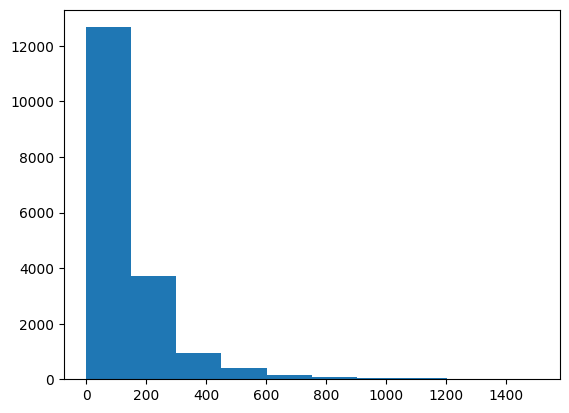

In [204]:
plt.hist(diff_mass_tn)

(array([1.437e+03, 3.140e+02, 1.060e+02, 2.600e+01, 1.100e+01, 4.000e+00,
        4.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([   0.     ,  116.84632,  233.69264,  350.53896,  467.38528,
         584.2316 ,  701.07792,  817.92424,  934.77056, 1051.61688,
        1168.4632 ]),
 <BarContainer object of 10 artists>)

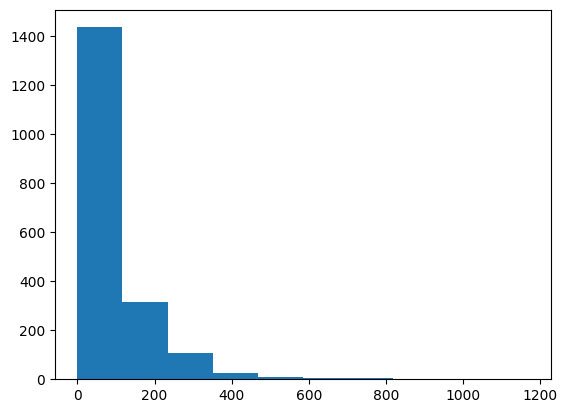

In [205]:
plt.hist(diff_mass_fn)

In [206]:
## Where the errors are ocurring more?
mass_fp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [207]:
mass_tp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [208]:
mass_tn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [209]:
mass_fn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fn]

Text(0.5, 0, 'mass')

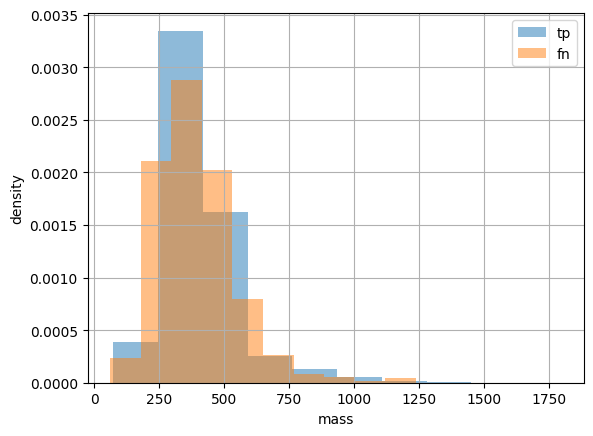

In [210]:
_= plt.hist(mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

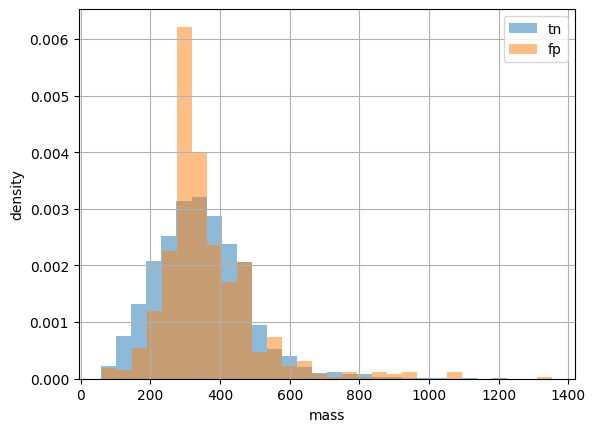

In [211]:
_=plt.hist(mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

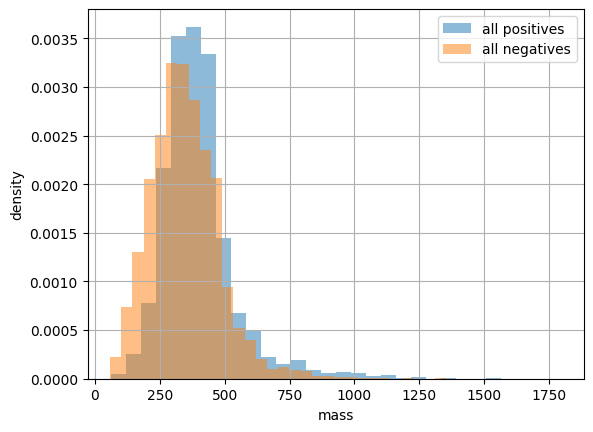

In [212]:
_=plt.hist(mass_tp + mass_fn, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_tn + mass_fp, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

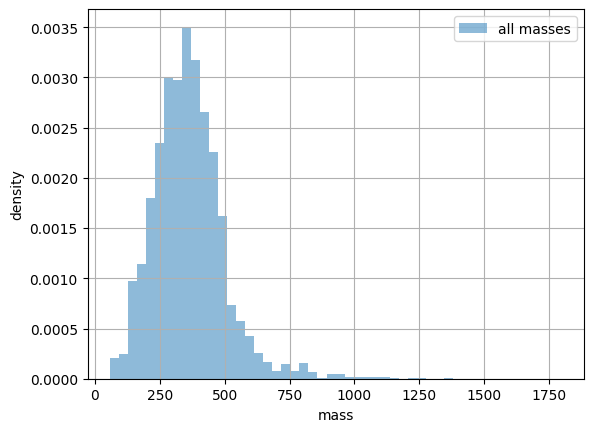

In [213]:
##all masses
_=plt.hist(mass_tp + mass_fn+mass_tn + mass_fp, label='all masses', alpha=0.5, bins=50,density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

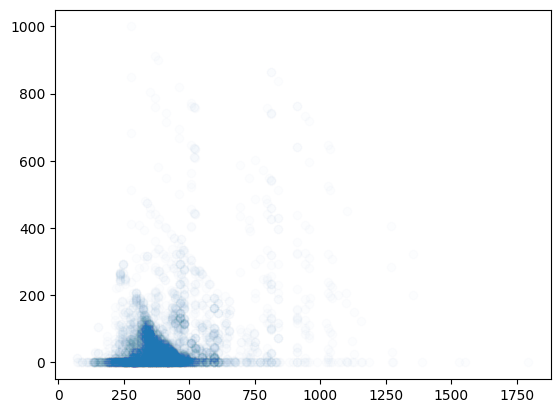

In [214]:
plt.scatter(mass_tp,diff_mass_tp, alpha=0.01)

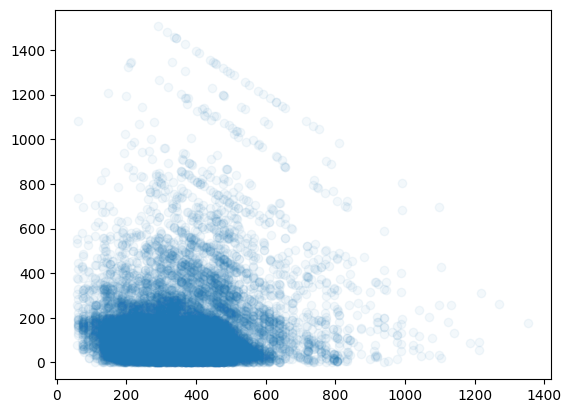

In [215]:
plt.scatter(mass_tn,diff_mass_tn, alpha=0.05)

## Are pairs with similarity equal 1 more prone to errors?

In [216]:
mol_1= [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans) if m.similarity==1]

In [217]:
mol_090= [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans)  if ((m.similarity<1)and(m.similarity>0.90))]

In [218]:
len(mol_1)

1880

In [219]:
len(mol_090)

785

In [220]:
scores_1 = np.array([m['score'] for m in mol_1])

In [221]:
scores_090 = np.array([m['score'] for m in mol_090])

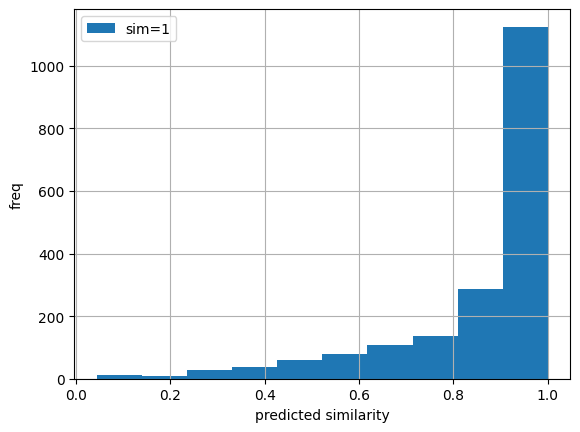

In [222]:
_=plt.hist(scores_1, label='sim=1')
plt.ylabel('freq')
plt.grid()
plt.xlabel('predicted similarity')
plt.legend()

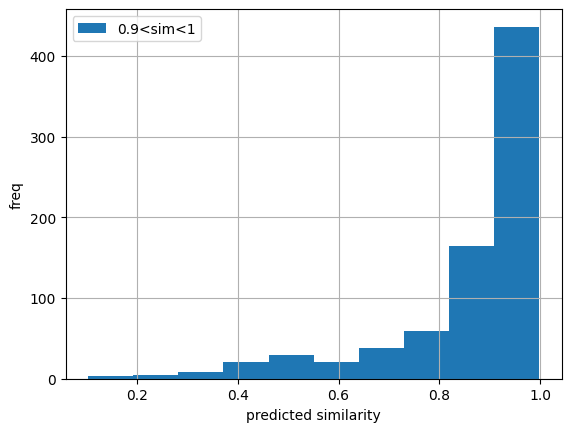

In [223]:
_=plt.hist(scores_090, label='0.9<sim<1')
plt.ylabel('freq')
plt.grid()
plt.xlabel('predicted similarity')
plt.legend()

In [224]:
len(scores_1[scores_1<0.5])/len(mol_1)

0.07287234042553191

In [225]:
len(scores_1[scores_1<0.5])

137

In [226]:
len(scores_090[scores_090<0.5])/len(scores_090)

0.05859872611464968

In [227]:
len(scores_090[scores_090<0.5])

46

In [228]:
scores_1[scores_1<0.5]

array([0.42550075, 0.40393448, 0.25408435, 0.48663527, 0.44228959,
       0.2038075 , 0.32388574, 0.46970057, 0.37452805, 0.23547789,
       0.38153702, 0.47430381, 0.49542961, 0.44979477, 0.38142827,
       0.38076341, 0.47064233, 0.3662166 , 0.18866375, 0.39430028,
       0.45953101, 0.49286208, 0.46696699, 0.32543823, 0.40235704,
       0.40161642, 0.43268481, 0.29681593, 0.30568188, 0.36686757,
       0.24421322, 0.04494022, 0.48080739, 0.47540399, 0.2884019 ,
       0.11837811, 0.48397729, 0.17201276, 0.43310198, 0.3574751 ,
       0.39053714, 0.49676493, 0.31289279, 0.47047904, 0.40824807,
       0.44023743, 0.44790044, 0.44565475, 0.37089509, 0.45011005,
       0.1265327 , 0.46671796, 0.15269856, 0.41346174, 0.48422042,
       0.43666458, 0.46038264, 0.05061455, 0.21059576, 0.19164565,
       0.14010242, 0.473391  , 0.44508395, 0.44204134, 0.40111619,
       0.08269609, 0.24795067, 0.25190753, 0.05827799, 0.24112467,
       0.42109767, 0.38230395, 0.47132456, 0.45724946, 0.28433

In [229]:
scores_090[scores_090<0.5]

array([0.49563113, 0.49813047, 0.29086882, 0.4078536 , 0.4420861 ,
       0.41771799, 0.38435555, 0.41272509, 0.45957863, 0.33898804,
       0.41385424, 0.18317518, 0.44357979, 0.42066962, 0.35115337,
       0.37764919, 0.2447072 , 0.4128319 , 0.35644889, 0.41764355,
       0.48449504, 0.22793117, 0.45943189, 0.23268339, 0.2473157 ,
       0.48479587, 0.48558718, 0.47228765, 0.3353866 , 0.47991589,
       0.44469595, 0.42800042, 0.37716651, 0.38651809, 0.48919478,
       0.42763731, 0.33001918, 0.44090253, 0.34175199, 0.4839187 ,
       0.34992358, 0.49703541, 0.42671591, 0.18638895, 0.43749645,
       0.10281468])

In [230]:
len(temp_molecule_pairs)

26650

In [231]:
bad_mol_1 = [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans)  if ((m.similarity==1)and(s<0.3))]

In [232]:
len(bad_mol_1)

40

In [362]:
bad_mol_1 = [{'i':i,'m':m,'score':s} for i,m,s in zip(range(0, len(scores_trans)),temp_molecule_pairs,scores_trans)  if ((m.similarity==1)and(s<0.3))]

In [455]:
len(bad_mol_1)/len(scores_trans)

0.00150093808630394

* remember that a unique spectra indexes several original spectra

In [440]:
target_index=25

In [441]:
bad_mol_1[target_index]

{'i': 25681,
 'm': <src.molecule_pair.MoleculePair at 0x2d819d9d0>,
 'score': 0.2955469787120819}

In [442]:
index_mol= bad_mol_1[target_index]['i']

In [443]:
temp_molecule_pairs.indexes_tani[index_mol]

array([147., 147.,   1.])

In [444]:
unique_index_0 = temp_molecule_pairs.indexes_tani[index_mol][0]
unique_index_1 = temp_molecule_pairs.indexes_tani[index_mol][1]

In [445]:
original_spectra_index_0=temp_molecule_pairs.df_smiles.loc[unique_index_0, 'indexes'][0]
original_spectra_index_1=temp_molecule_pairs.df_smiles.loc[unique_index_0, 'indexes'][-1]

In [446]:
spectra_index_0 = temp_molecule_pairs.spectrums_original[original_spectra_index_0]
spectra_index_1 = temp_molecule_pairs.spectrums_original[original_spectra_index_1]

In [447]:
spectra_index_1.params

{'pepmass': (142.026, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'ESI-Orbitrap',
 'filename': 'birmingham_pos.mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'BIRMINGHAM-UHPLC-MS-POS',
 'name': 'Phosphoryethanolamine - 40.0 eV M+H',
 'pi': 'PI',
 'datacollector': 'Data Collector',
 'smiles': 'C(COP(=O)(O)O)N',
 'inchi': 'N/A',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00006120547',
 'scans': '4675'}

In [448]:
spectra_index_1.mz

array([ 83.570198,  98.9841  , 104.4039  , 107.1399  , 142.026001,
       164.657898])

In [449]:
spectra_index_1.intensity

array([ 7620.9 , 22832.6 ,  8121.21,  8110.21, 46200.3 ,  7976.74],
      dtype=float32)

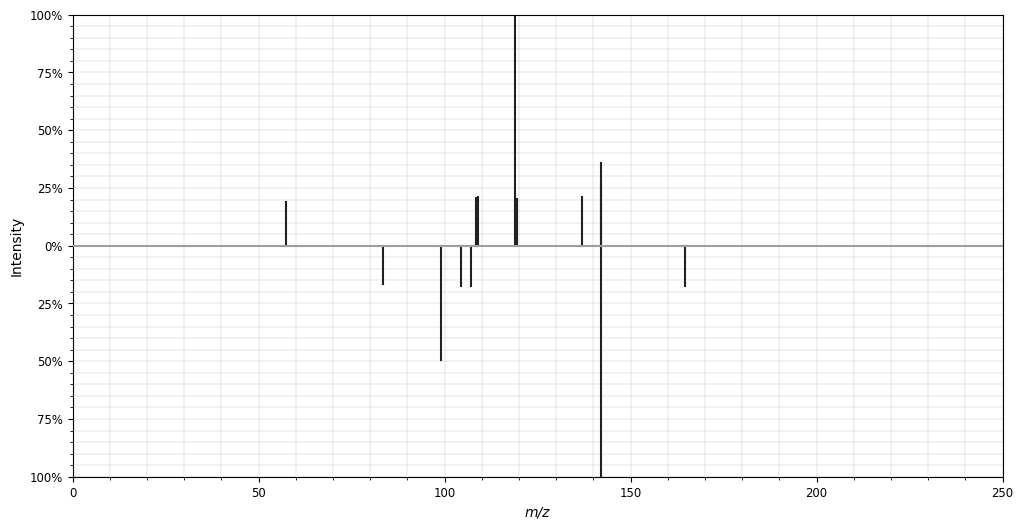

In [450]:
Plotting.plot_mirror_plot(spectra_index_0, spectra_index_1)